In [21]:
import os
import logging
import tempfile
from pathlib import Path

import rasterio
import geopandas as gpd
import numpy as np
import numpy.typing as npt
import rasterio.mask
from rasterio.crs import CRS
from rasterio.warp import calculate_default_transform, reproject, Resampling

here = Path.cwd() / "data"

def convert_crs(
    file: str | Path, dst_crs: str = "EPSG:4326", resampling=Resampling.bilinear
) -> str | Path:
    "Reproject raster to different CRS"
    with rasterio.open(file) as src:
        if src.crs == dst_crs:  # no projection needed
            logging.info(
                f"No projection needed as source and destination CRS are identical: {src.crs}"
            )
            return file
        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds
        )
        kwargs = src.meta.copy()
        kwargs.update(
            {"crs": dst_crs, "transform": transform, "width": width, "height": height}
        )

        handle, tmpfile = tempfile.mkstemp(suffix=".tif", prefix="dartagg")
        os.close(handle)

        with rasterio.open(tmpfile, "w", **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=resampling,
                )
        return tmpfile

def raster_mask(file: str | Path, geometry: gpd.GeoSeries) -> npt.ArrayLike:
    """Mask raster file with a set of geometries

    Parameters
    ----------
    file
        Raster file to read
    geometry
        Geometry column of a GeoDataFrame, can be accessed by the .geometry attribute

    Returns
    -------
    np.array
        Array of the same shape as the raster data, but with values outside the polygons
        defined by the geometry set to NaN
    """

    print("\nraster_mask reading:", file)
    with rasterio.open(file) as src:
        masked, transform = rasterio.mask.mask(src, geometry, crop=True)
        masked = masked.squeeze()
        masked[masked == src.nodata] = 0
        print("\tcrs:", src.crs)
        print("\tbounds:", src.bounds)
    print("\ttransform:", transform)
    print("\tshape:", masked.shape)
    return masked, transform

def resample_to_destination(
    source_data: npt.ArrayLike,
    source_transform,
    destination: npt.ArrayLike,
    destination_transform,
    crs: CRS | str,
    resampling,
) -> npt.ArrayLike:
    """Resamples source raster to match destination mask

    NOTE: This function is not working at the moment

    Parameters
    ----------
    source_data
        Source raster file
    source_transform
        Source transform function
    destination
        Destination raster data as a numpy array, this is only used to get the shape
    destination_transform
        Destination transform
    target_crs
        Target CRS
    bounds
         Geometry bounds
    resampling
        Resampling method, one of `rasterio.enums.Resampling`

    Returns
    -------
    np.array
        Resampled raster data in an array
    """
    print("Resampling using:", resampling)
    # drop the first index (1)
    height, width = destination.shape  # type: ignore
    assert isinstance(width, int) and isinstance(height, int)
    # Create an empty array to hold the resampled data
    resampled_data = np.zeros((height, width), dtype=np.float32)

    # Perform the resampling using reproject function
    reproject(
        source=source_data,
        destination=resampled_data,
        src_transform=source_transform,
        src_crs=crs,
        dst_transform=destination_transform,
        dst_crs=crs,
        resampling=resampling,  # Choose resampling method (nearest, bilinear, etc.)
    )
    return resampled_data

# Read shapefile data
city_polygons = gpd.read_file(
    here / "vnm_adm_gov_20201027" / "vnm_admbnda_adm2_gov_20201027.shp"
)
print("Number of city polygons:", len(city_polygons))

Number of city polygons: 708


In [2]:
# Ensure that CRS of all rasters and vector are the same
aedes_raster_file = convert_crs(here / "aegypti.tif", city_polygons.crs.srs)
print("Aedes raster file (converted):", aedes_raster_file)
population_raster_file = convert_crs(
    here / "vnm_ppp_2020_UNadj_constrained.tif", city_polygons.crs.srs
)
print("Population raster file (converted):", population_raster_file)

aedes_masked, aedes_masked_transform = raster_mask(aedes_raster_file, city_polygons.geometry)
population_masked_high, population_masked_transform = raster_mask(population_raster_file, city_polygons.geometry)


Aedes raster file (converted): /var/folders/2t/8v1v9w8s191f91fnq_f9t0600000gn/T/dartaggwcvrej8w.tif
Population raster file (converted): /Users/abhidg/ghq/github.com/kraemer-lab/DART-Aggregation/data/vnm_ppp_2020_UNadj_constrained.tif

raster_mask reading: /var/folders/2t/8v1v9w8s191f91fnq_f9t0600000gn/T/dartaggwcvrej8w.tif
	crs: EPSG:4326
	bounds: BoundingBox(left=-180.0, bottom=-60.0, right=179.99985600000002, top=84.999942)
	transform: | 0.04, 0.00, 102.12|
| 0.00,-0.04, 23.42|
| 0.00, 0.00, 1.00|
	shape: (390, 378)

raster_mask reading: /Users/abhidg/ghq/github.com/kraemer-lab/DART-Aggregation/data/vnm_ppp_2020_UNadj_constrained.tif
	crs: EPSG:4326
	bounds: BoundingBox(left=102.145416273, bottom=8.562916834, right=109.46958291, top=23.392916775)
	transform: | 0.00, 0.00, 102.15|
| 0.00,-0.00, 23.39|
| 0.00, 0.00, 1.00|
	shape: (17796, 8789)


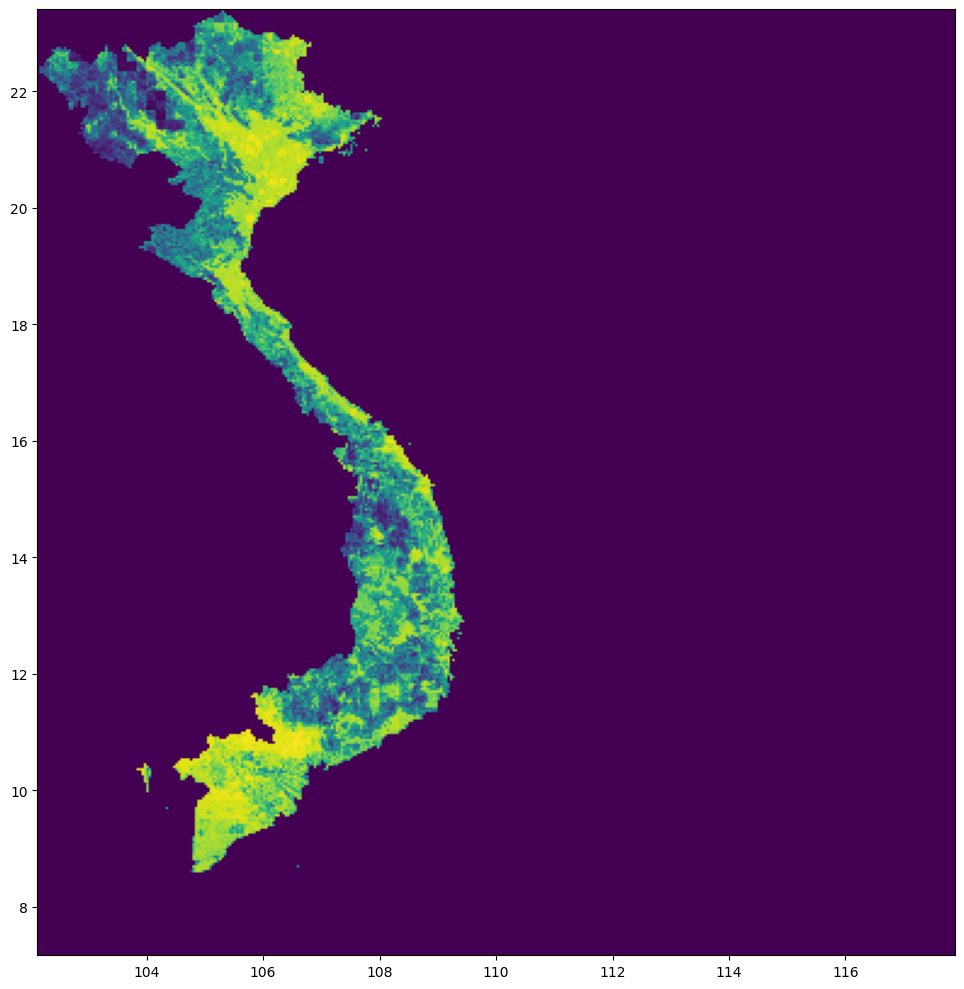

<Axes: >

In [35]:
import matplotlib.pyplot as plt
import rasterio.plot
rasterio.plot.show(aedes_masked, transform=aedes_masked_transform)

In [28]:
magnification = 1
plt.rcParams["figure.figsize"] = [20, 10]
plt.rcParams["figure.autolayout"] = True
population_masked_high.min()

np.float32(0.0)

In [22]:
population_masked_low = resample_to_destination(
    population_masked_high,
    population_masked_transform,
    aedes_masked,
    aedes_masked_transform,
    city_polygons.crs,
    resampling=Resampling.sum
)

Resampling using: 13


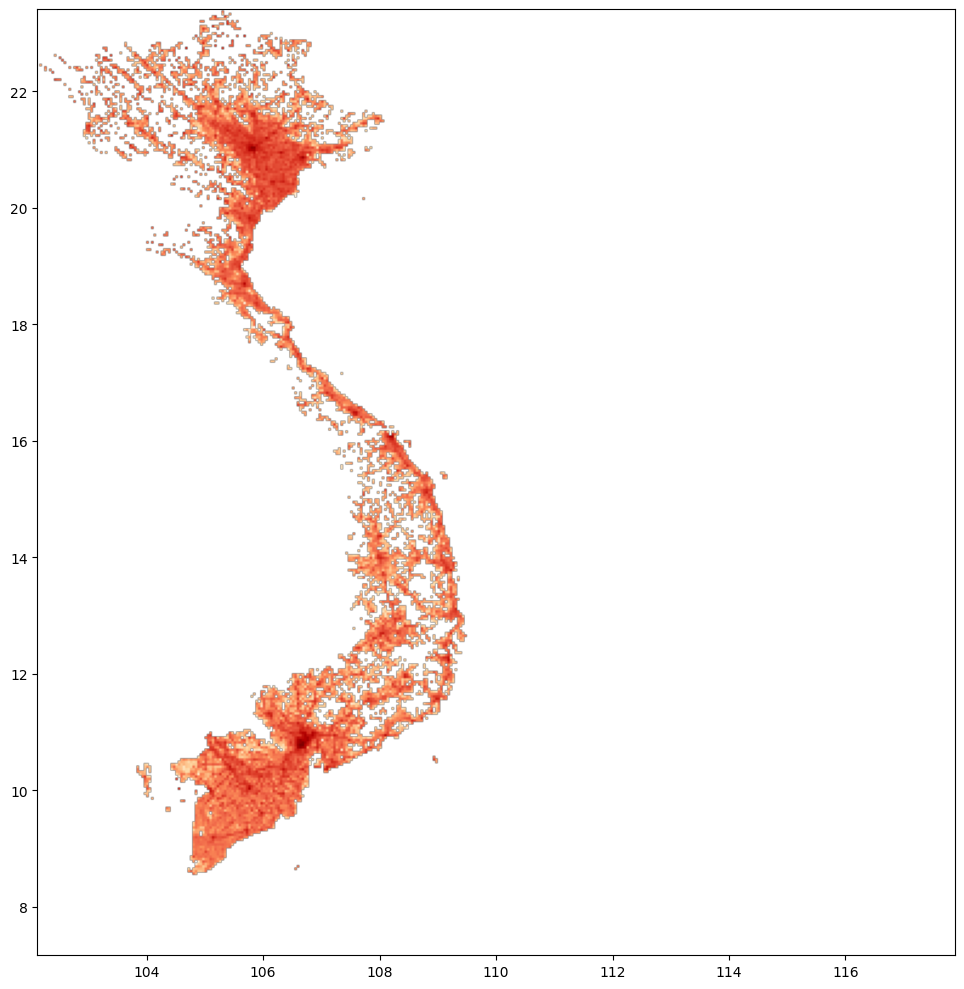

<Axes: >

In [39]:
rasterio.plot.show(population_masked_low, cmap='OrRd', norm='log', transform=aedes_masked_transform)

In [24]:
population_masked_low

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(390, 378), dtype=float32)

In [26]:
population_masked_low.max()

np.float32(1123080.1)

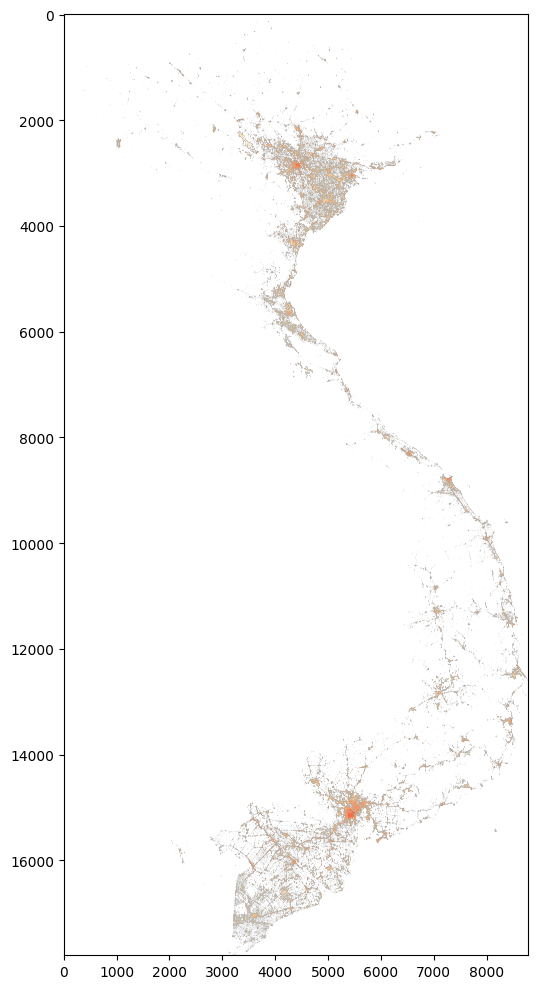

In [31]:
plt.imshow(population_masked_high, cmap='OrRd', norm='log')

In [32]:
np.sum(population_masked_low), np.sum(population_masked_high)

(np.float32(97411256.0), np.float32(97411280.0))